In [1]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

#I/O
import h5py
import pickle
import glob
import copy
import time

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

from sklearn.preprocessing import StandardScaler

/opt/miniconda3/envs/IWST/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
def DHC_iso_vec(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1)))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

In [3]:
mnist_train_y = hd5_open('../../DHC/scratch_AKS/mnist_train_y.h5','main/data')
mnist_test_y = hd5_open('../../DHC/scratch_AKS/mnist_test_y.h5','main/data')

In [4]:
mnist_DHC_out_sizetrain = hd5_open('../from_cannon/2021_01_21/mnist_DHC_train_ang_1_1.h5','main/data')
mnist_DHC_out_sizetest = hd5_open('../from_cannon/2021_01_21/mnist_DHC_test_ang_1_1.h5','main/data')
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_out_sizetest,5,8)
mnist_DHC_out_size_iso_train = DHC_iso_vec(mnist_DHC_out_sizetrain,5,8)

In [5]:
np.repeat(mnist_train_y,6)[0:10],mnist_train_y.shape

(array([5, 5, 5, 5, 5, 5, 0, 0, 0, 0]), (60000,))

In [5]:
M = 100
angle_train = np.tile([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],60000)

In [6]:
M = 100
angle_array = [i for i in np.linspace(2*np.pi/M,2*np.pi,M)]
angle_test = np.tile(angle_array,10000)

In [46]:
angle_test

array([0.06283185, 0.12566371, 0.18849556, ..., 6.1575216 , 6.22035345,
       6.28318531])

In [7]:
from sklearn.linear_model import LinearRegression

In [42]:
sc = StandardScaler()
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_size_iso_train))
Y_tr = angle_train
Y_test = angle_test
X_test = sc.transform(np.log10(mnist_DHC_out_size_iso))

eval_list =[]
rank = []
test_prec =[]
train_prec =[]
test_prec_class = []
prec = []

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(2.903143631625974, 3.9324429411635706)

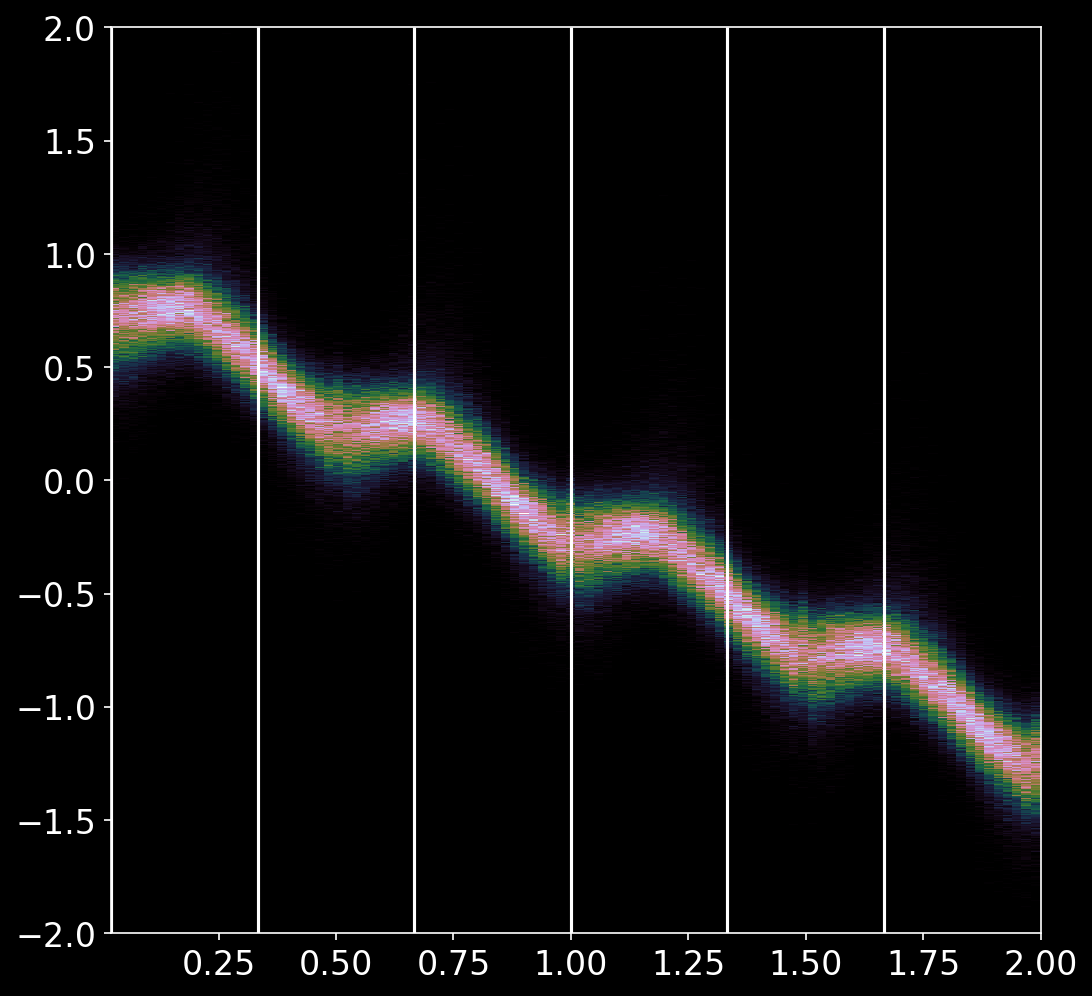

In [36]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(Y_test/np.pi, (y_pred_test-Y_test)/np.pi, bins=[100,2000],cmap='cubehelix')
plt.ylim([-2,2])
for i in np.array([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3])/np.pi:
    plt.vlines(i,-2,2,'w')
plt.show()

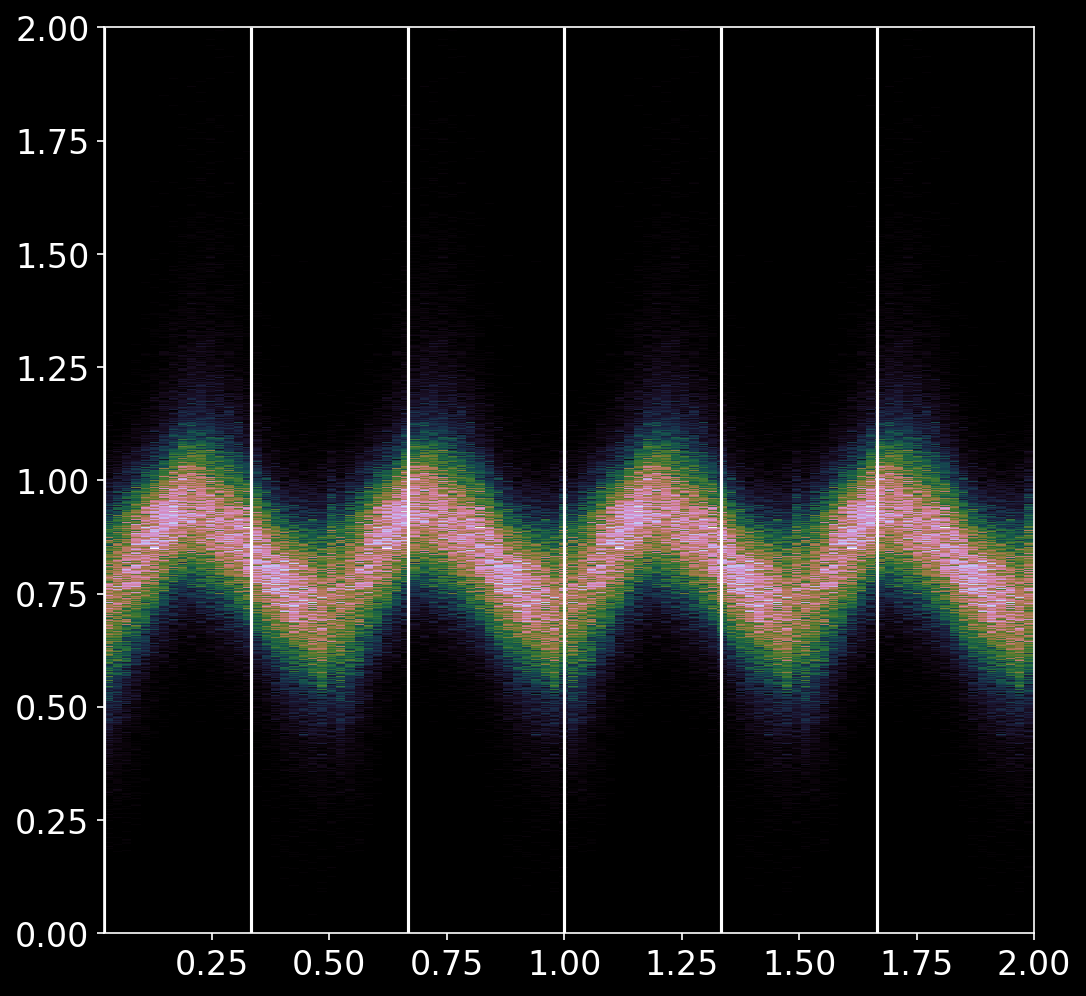

In [45]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(Y_test/np.pi, y_pred_test/np.pi, bins=[100,2000],cmap='cubehelix')
plt.ylim([0,2])
for i in np.array([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3])/np.pi:
    plt.vlines(i,-2,2,'w')
plt.show()

In [46]:
sc = StandardScaler()
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain))
Y_tr = angle_train
Y_test = angle_test
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest))

eval_list =[]
rank = []
test_prec =[]
train_prec =[]
test_prec_class = []
prec = []

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(2.2611588929556903, 3.6203084245603425)

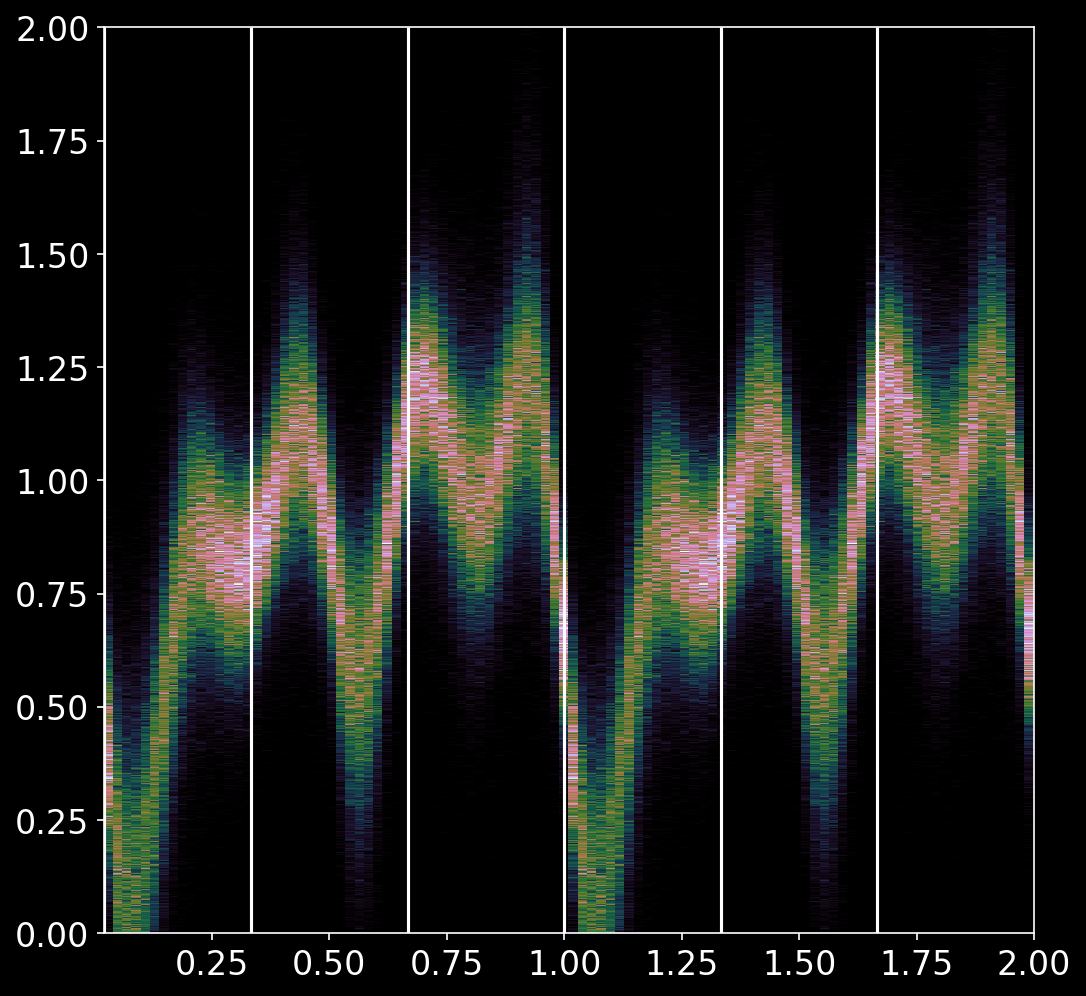

In [47]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(Y_test/np.pi, y_pred_test/np.pi, bins=[100,2000],cmap='cubehelix')
plt.ylim([0,2])
for i in np.array([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3])/np.pi:
    plt.vlines(i,-2,2,'w')
plt.show()

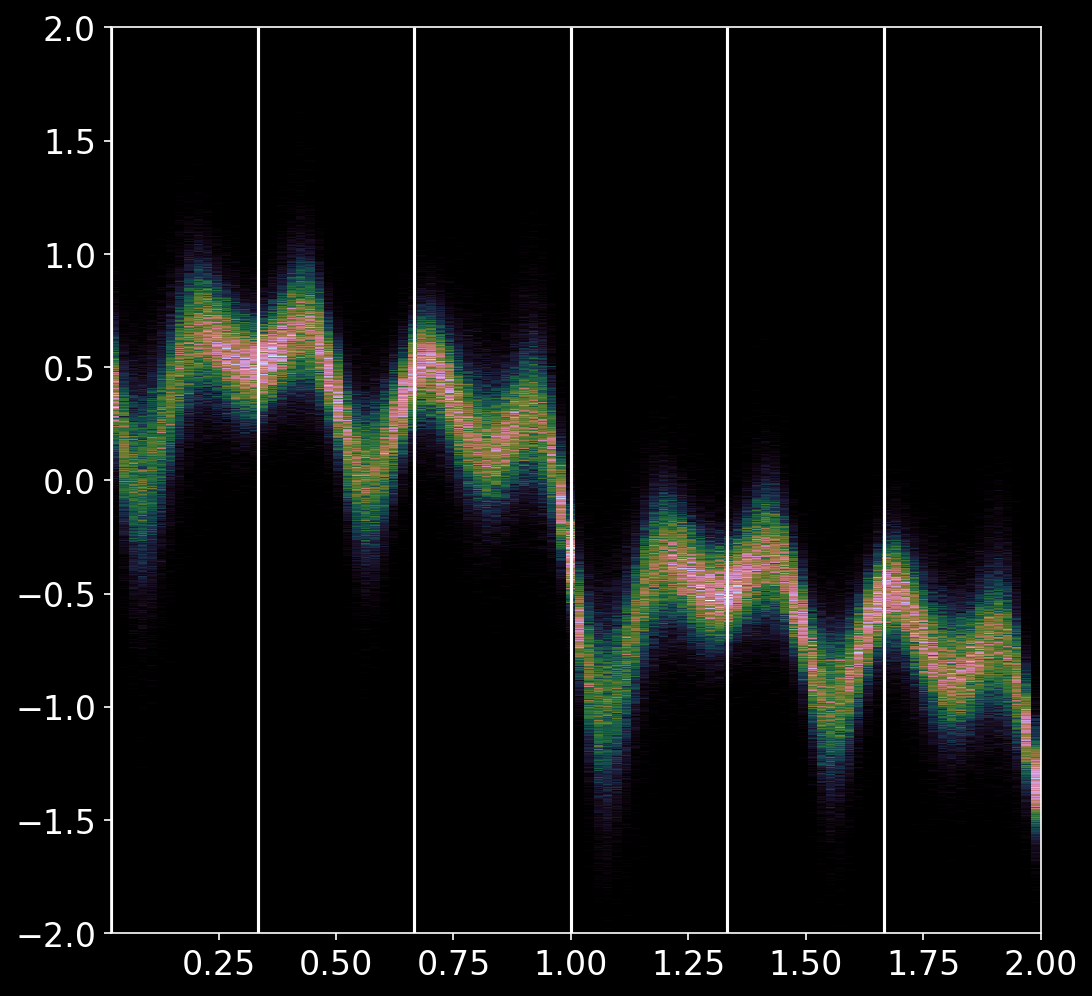

In [48]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(Y_test/np.pi, (y_pred_test-Y_test)/np.pi, bins=[100,2000],cmap='cubehelix')
plt.ylim([-2,2])
for i in np.array([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3])/np.pi:
    plt.vlines(i,-2,2,'w')
plt.show()

In [54]:
sc = StandardScaler()
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain))
Y_tr = np.mod(angle_train,np.pi)
Y_test = np.mod(angle_test,np.pi)
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(0.03558839060408986, 1.3719642092988502)

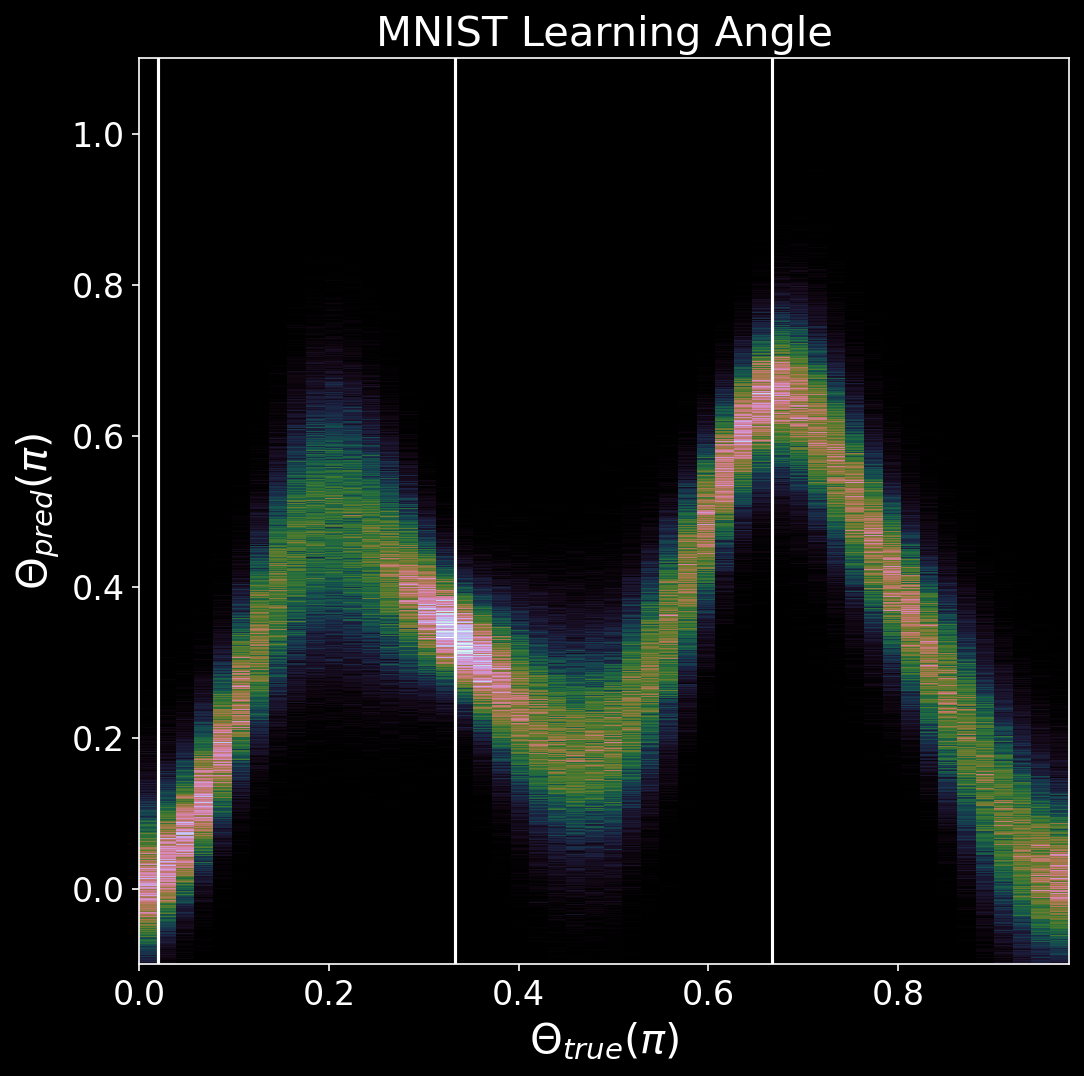

In [64]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(Y_test/np.pi, y_pred_test/np.pi, bins=[50,1000],cmap='cubehelix')
plt.ylim([-0.1,1.1])
for i in np.array([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3])/np.pi:
    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

In [65]:
sc = StandardScaler()
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain))
Y_tr = np.tan(np.mod(angle_train,np.pi))
Y_test = np.tan(np.mod(angle_test,np.pi))
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(0.10523712456007986, 3.0537826495057197e+30)

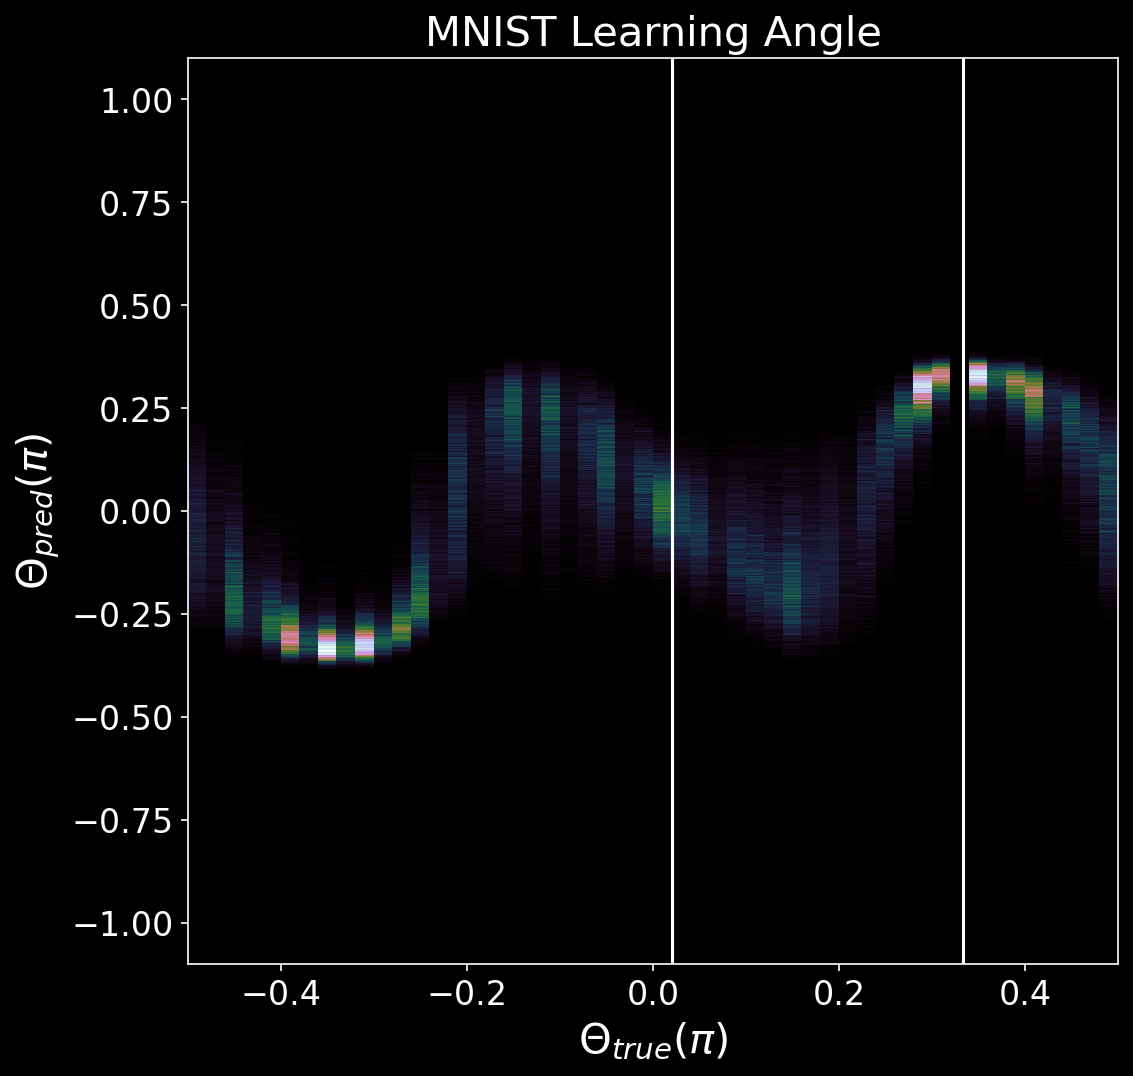

In [68]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(np.arctan(Y_test)/np.pi, np.arctan(y_pred_test)/np.pi, bins=[50,1000],cmap='cubehelix')
plt.ylim([-1.1,1.1])
for i in np.array([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3])/np.pi:
    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

In [69]:
sc = StandardScaler()
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain))
Y_tr = np.tan(np.mod(angle_train,np.pi)-0.5)
Y_test = np.tan(np.mod(angle_test,np.pi)-0.5)
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(20.899326639502327, 2619.573055607023)

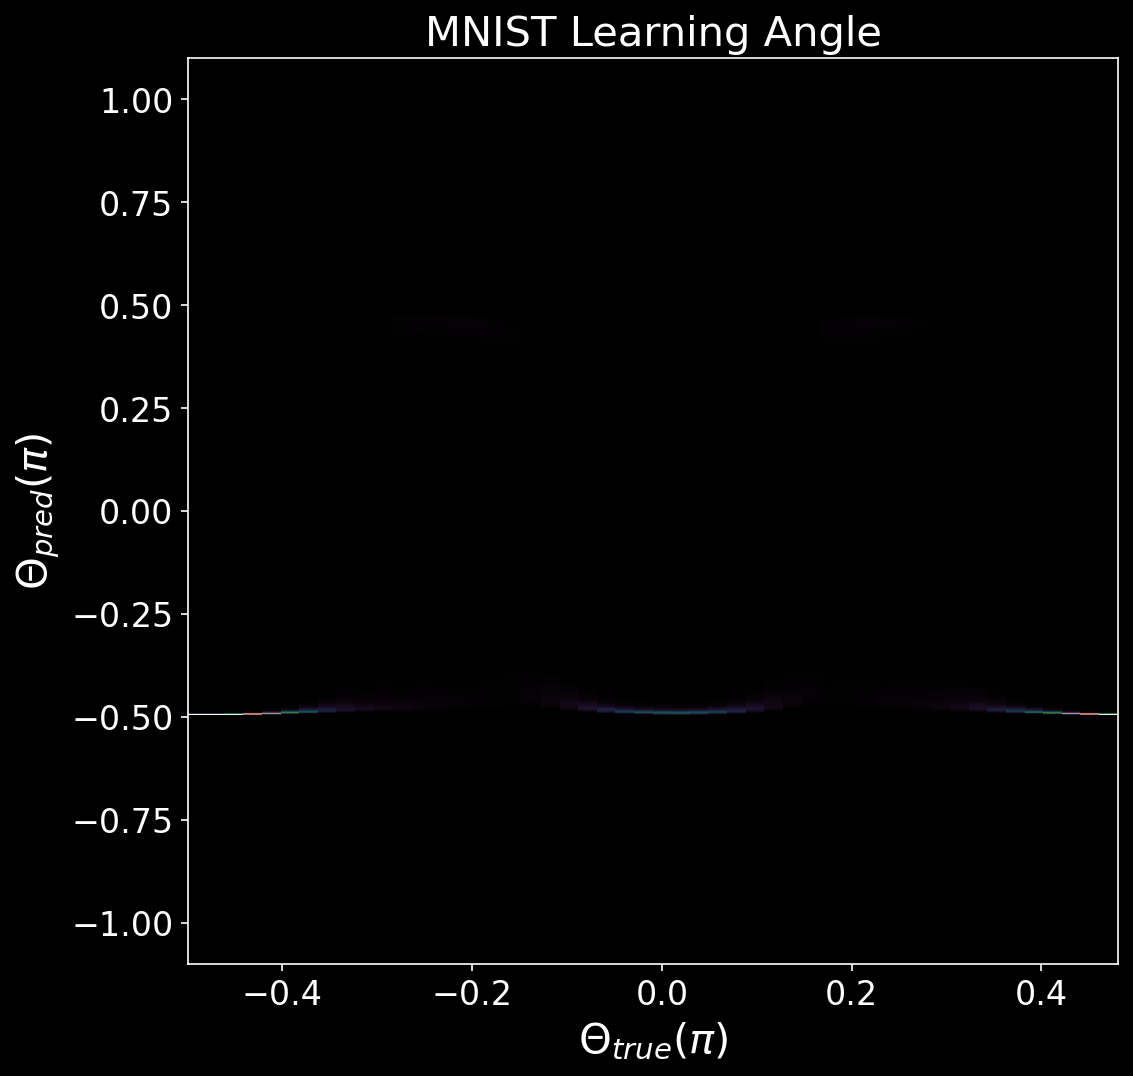

In [72]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(np.arctan(Y_test)/np.pi, np.arctan(y_pred_test)/np.pi, bins=[50,1000],cmap='cubehelix')
plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

In [9]:
hot_vec = np.array([np.cos(np.mod(angle_train,np.pi)),np.sin(np.mod(angle_train,np.pi))]).T

In [10]:
hot_vec.shape

(360000, 2)

In [11]:
sc = StandardScaler()
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain))
Y_tr = np.array([np.cos(np.mod(angle_train,np.pi)),np.sin(np.mod(angle_train,np.pi))]).T
Y_test = np.array([np.cos(np.mod(angle_test,np.pi)),np.sin(np.mod(angle_test,np.pi))]).T
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(0.013799534399281, 0.40870274299659326)

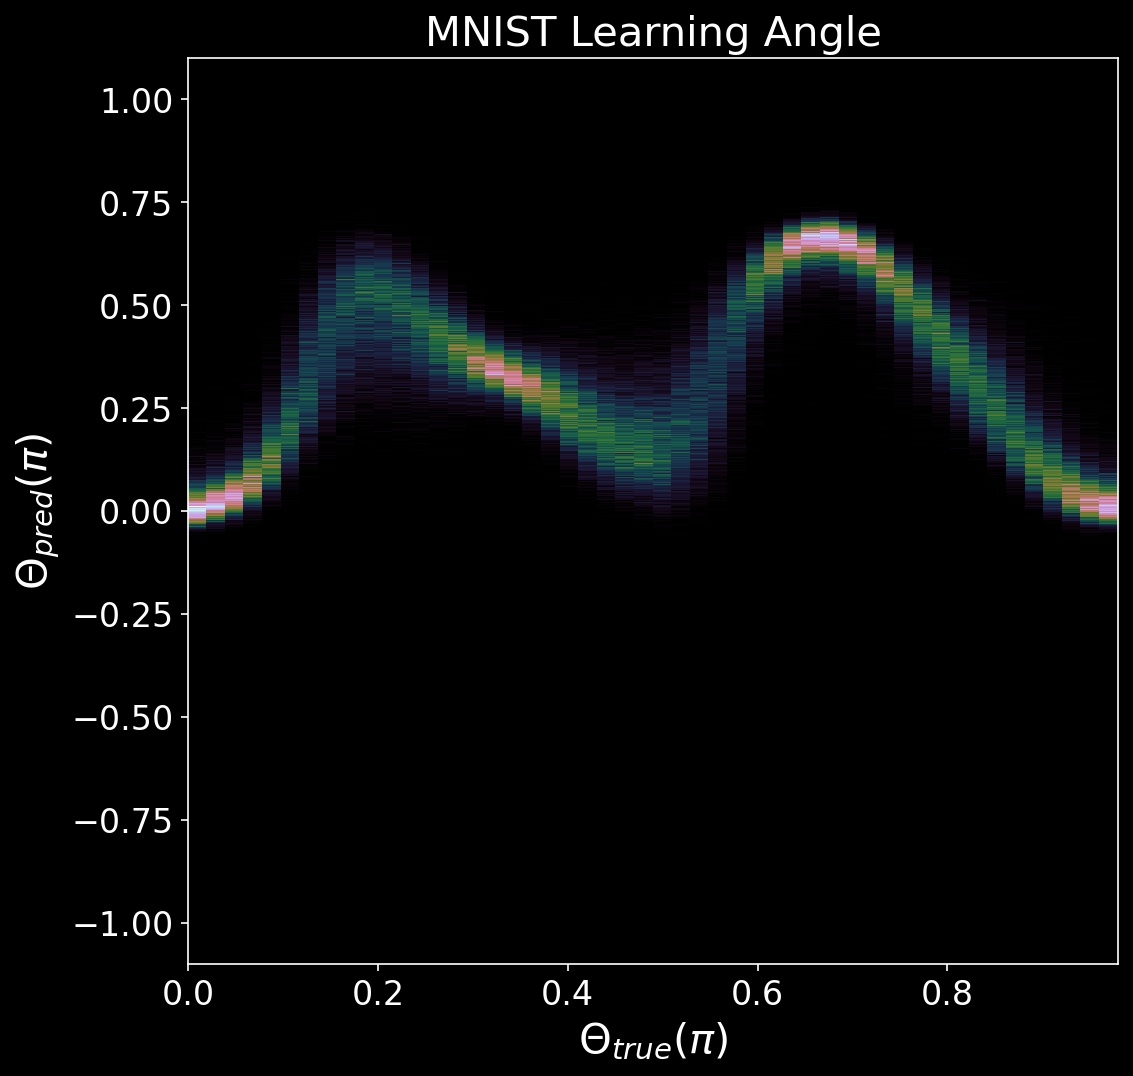

In [16]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi, np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi, 
          bins=[50,1000],cmap='cubehelix')
plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

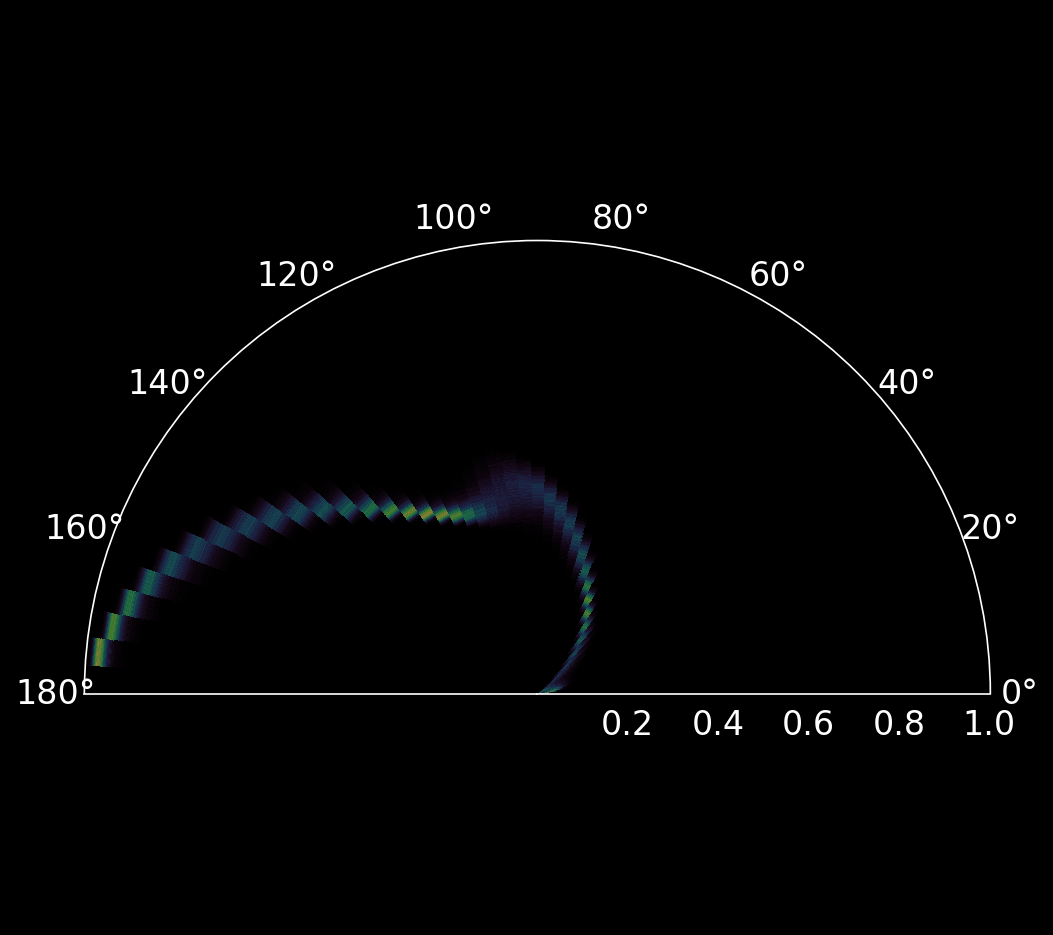

In [23]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111,projection='polar') 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(np.arctan2(Y_test[:,1],Y_test[:,0]), np.abs((np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi-np.arctan2(Y_test[:,1],Y_test[:,0]))/np.pi), 
          bins=[50,1000],cmap='cubehelix')
plt.xlim([0,np.pi])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

#plt.ylabel('$\Theta_{pred} (\pi)$')
#plt.xlabel('$\Theta_{true} (\pi)$')
#plt.title('MNIST Learning Angle')
plt.show()

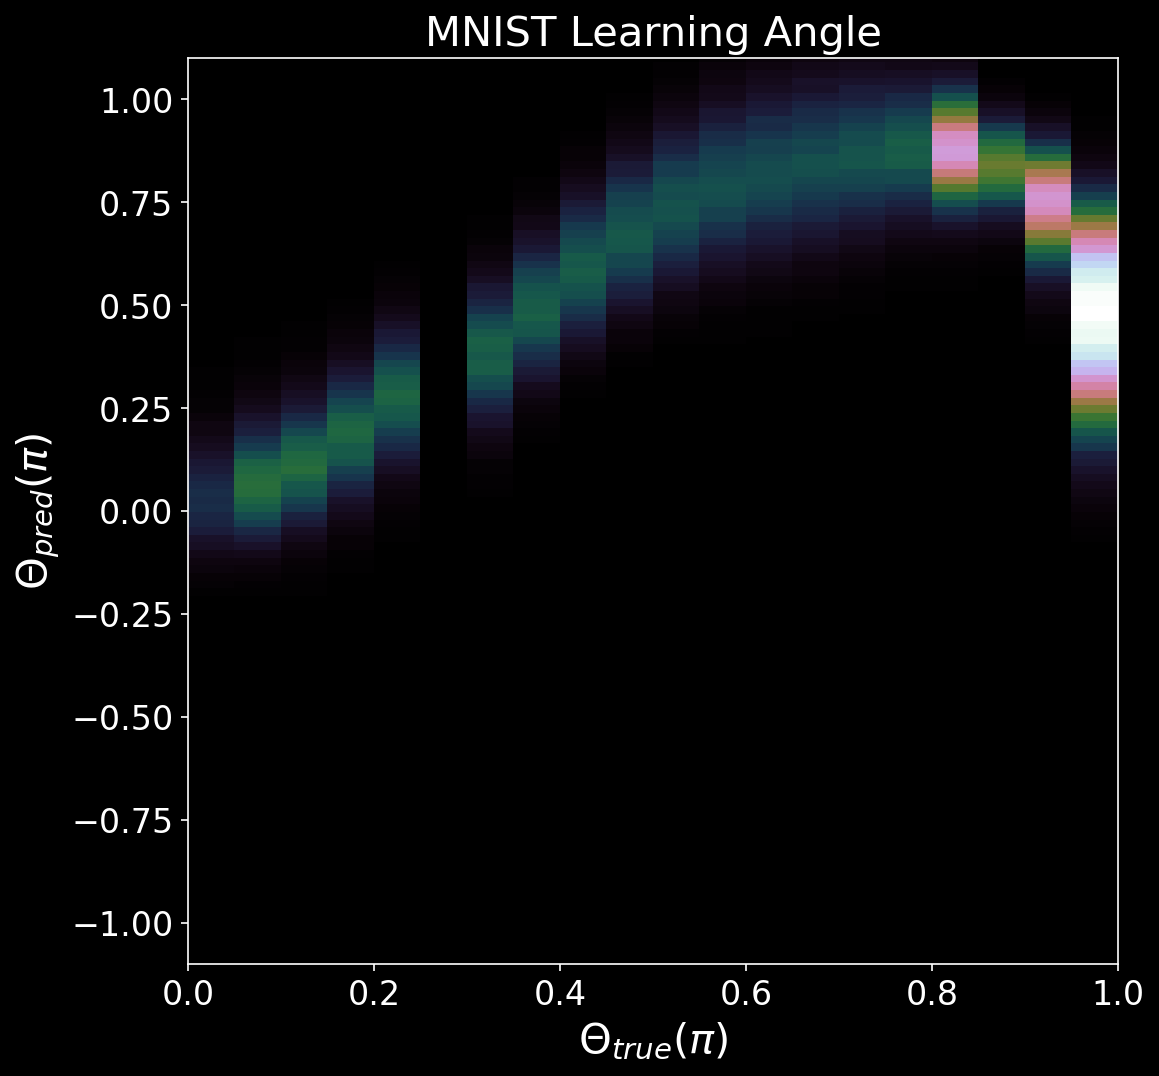

In [27]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(Y_test[:,1], y_pred_test[:,1], 
          bins=[20,100],cmap='cubehelix')
plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

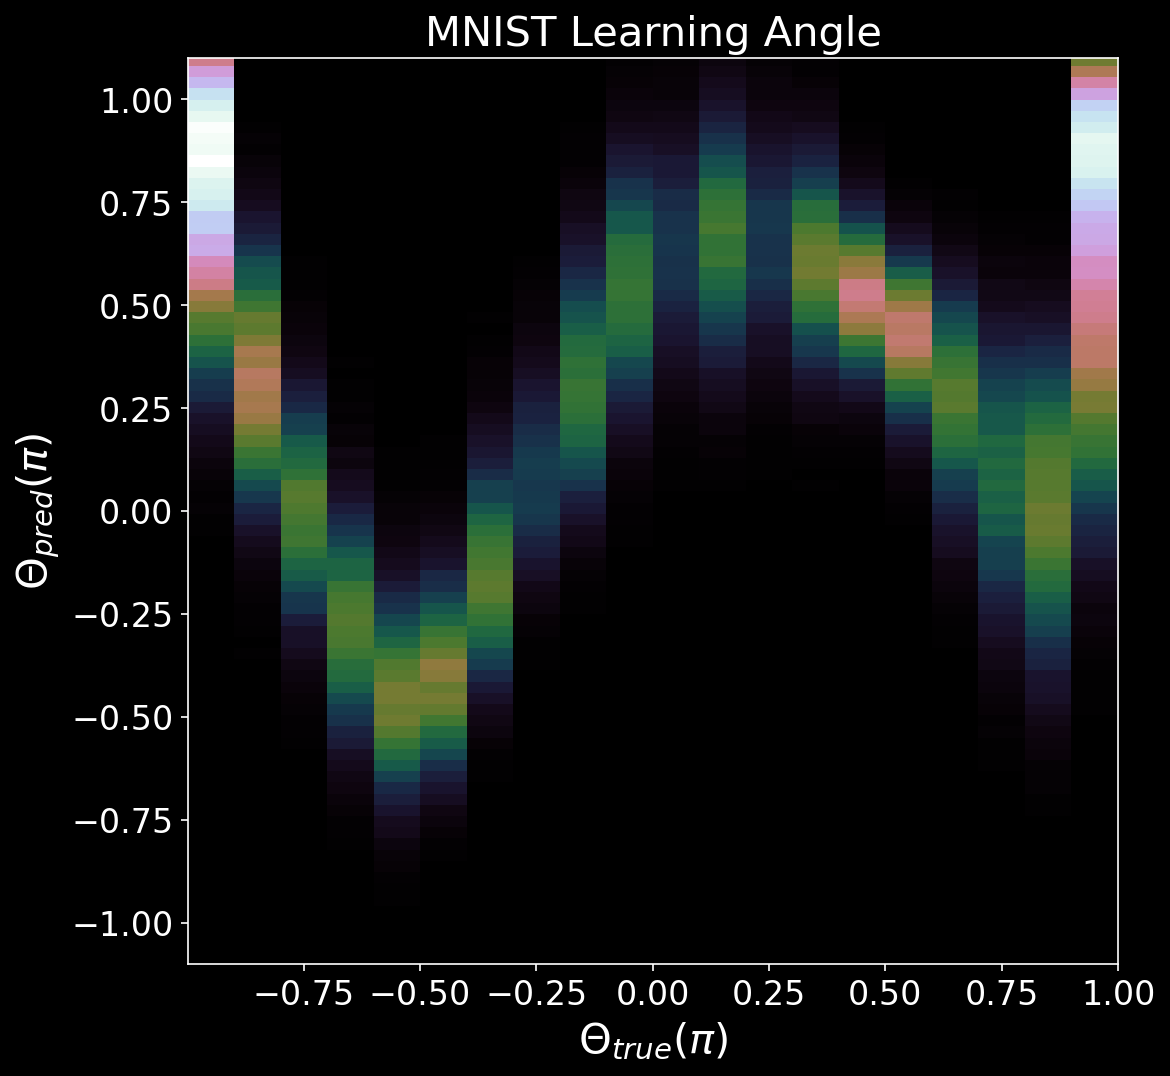

In [28]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(Y_test[:,0], y_pred_test[:,0], 
          bins=[20,100],cmap='cubehelix')
plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

In [30]:
angle_array = [i for i in np.linspace(2*np.pi/M,2*np.pi,M)]
angle_array

[0.06283185307179587,
 0.12566370614359174,
 0.1884955592153876,
 0.25132741228718347,
 0.3141592653589793,
 0.37699111843077515,
 0.4398229715025711,
 0.5026548245743669,
 0.5654866776461628,
 0.6283185307179586,
 0.6911503837897545,
 0.7539822368615504,
 0.8168140899333463,
 0.8796459430051421,
 0.942477796076938,
 1.0053096491487339,
 1.0681415022205298,
 1.1309733552923258,
 1.1938052083641215,
 1.2566370614359175,
 1.3194689145077132,
 1.3823007675795091,
 1.445132620651305,
 1.5079644737231008,
 1.5707963267948968,
 1.6336281798666927,
 1.6964600329384885,
 1.7592918860102844,
 1.8221237390820804,
 1.884955592153876,
 1.947787445225672,
 2.0106192982974678,
 2.0734511513692637,
 2.1362830044410597,
 2.1991148575128556,
 2.261946710584651,
 2.324778563656447,
 2.387610416728243,
 2.450442269800039,
 2.513274122871835,
 2.5761059759436304,
 2.6389378290154264,
 2.7017696820872223,
 2.7646015351590183,
 2.8274333882308142,
 2.89026524130261,
 2.9530970943744057,
 3.0159289474462017,

In [44]:
angle_array[0:25:2]

[0.06283185307179587,
 0.1884955592153876,
 0.3141592653589793,
 0.4398229715025711,
 0.5654866776461628,
 0.6911503837897545,
 0.8168140899333463,
 0.942477796076938,
 1.0681415022205298,
 1.1938052083641215,
 1.3194689145077132,
 1.445132620651305,
 1.5707963267948968]

In [52]:
sc = StandardScaler()
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetest[np.isin(angle_test,angle_array[1:25:2])]))
Y_tr = np.array([np.cos(np.mod(angle_test[np.isin(angle_test,angle_array[1:25:2])],np.pi)),np.sin(np.mod(angle_test[np.isin(angle_test,angle_array[1:25:2])],np.pi))]).T
Y_test = np.array([np.cos(np.mod(angle_test[np.isin(angle_test,angle_array[0:25:2])],np.pi)),np.sin(np.mod(angle_test[np.isin(angle_test,angle_array[0:25:2])],np.pi))]).T
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest[np.isin(angle_test,angle_array[0:25:2])]))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(0.008835698241184756, 0.013849681592804726)

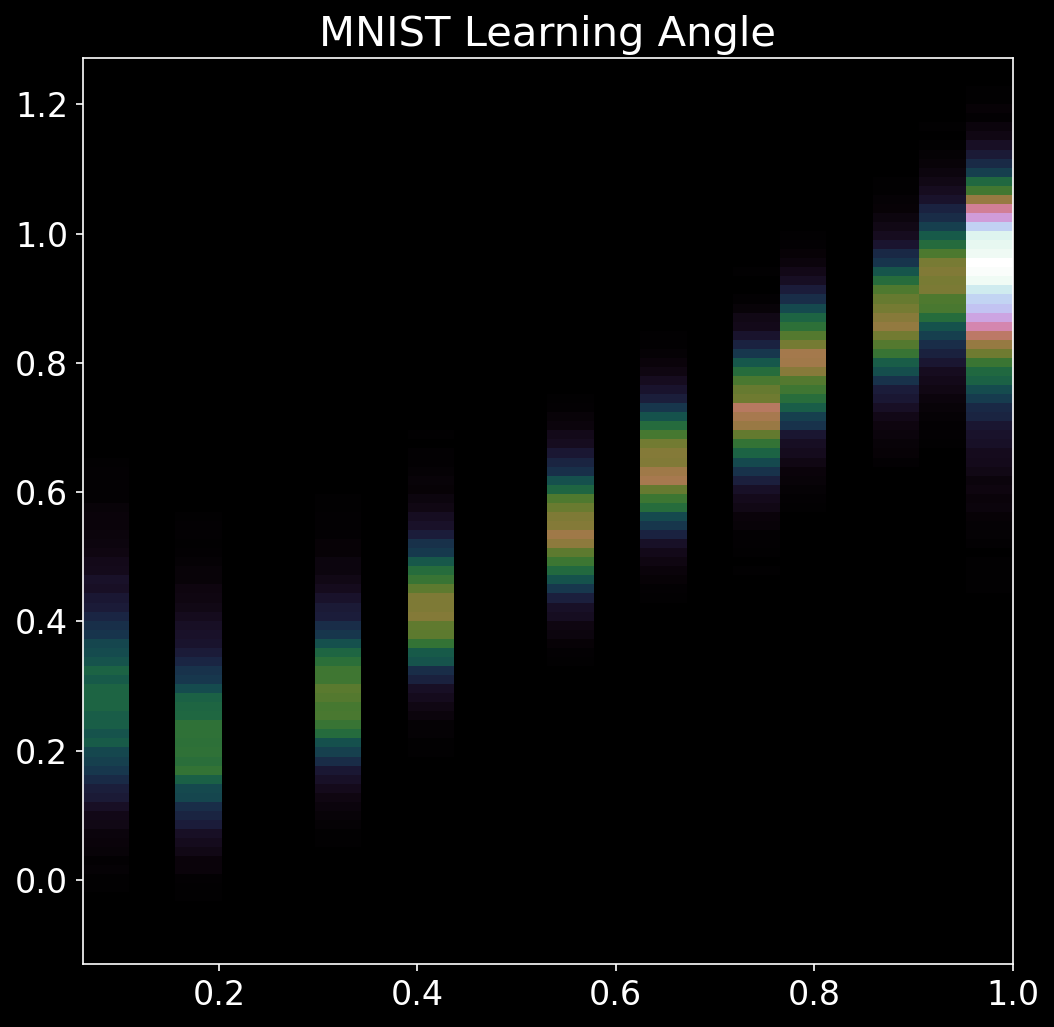

In [53]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(Y_test[:,1], y_pred_test[:,1], 
          bins=[20,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

#plt.ylabel('$\Theta_{pred} (\pi)$')
#plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

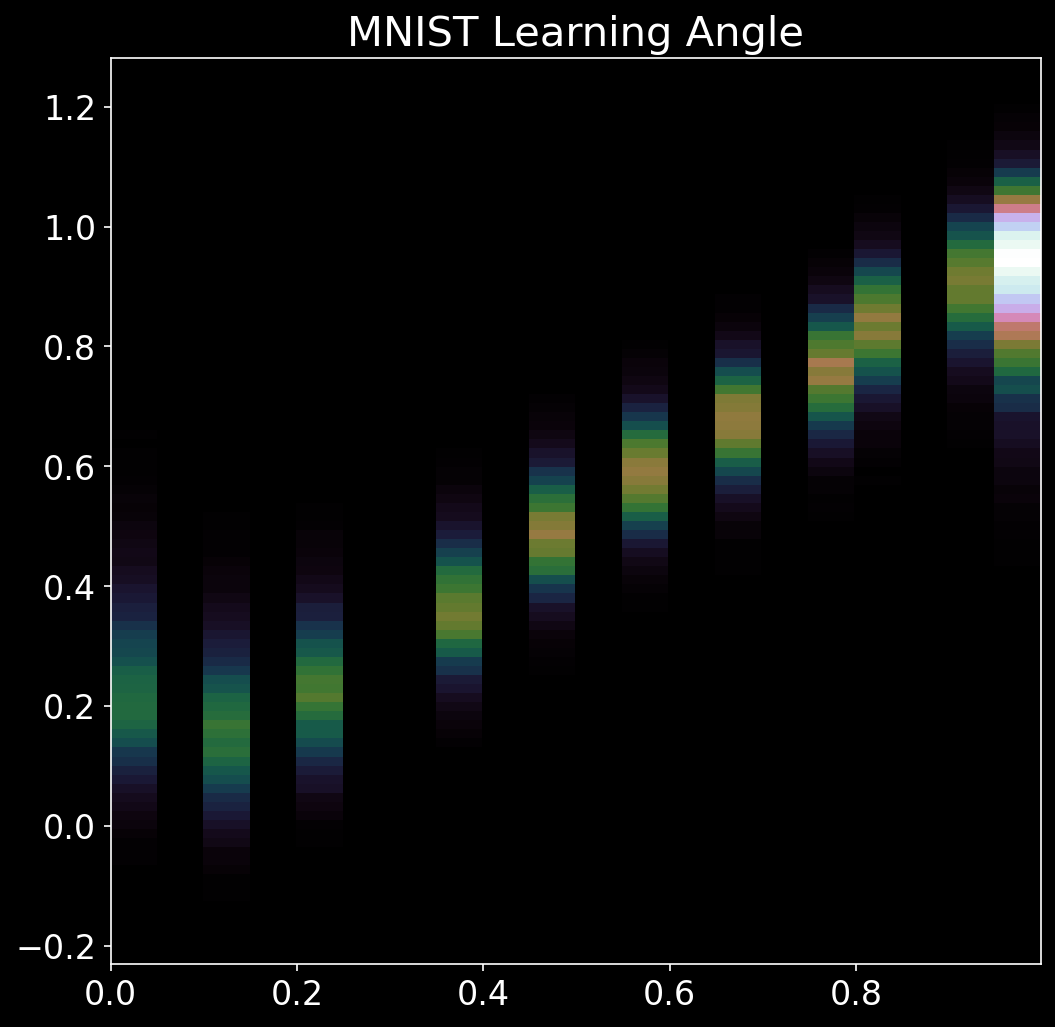

In [54]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(Y_test[:,0], y_pred_test[:,0], 
          bins=[20,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

#plt.ylabel('$\Theta_{pred} (\pi)$')
#plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

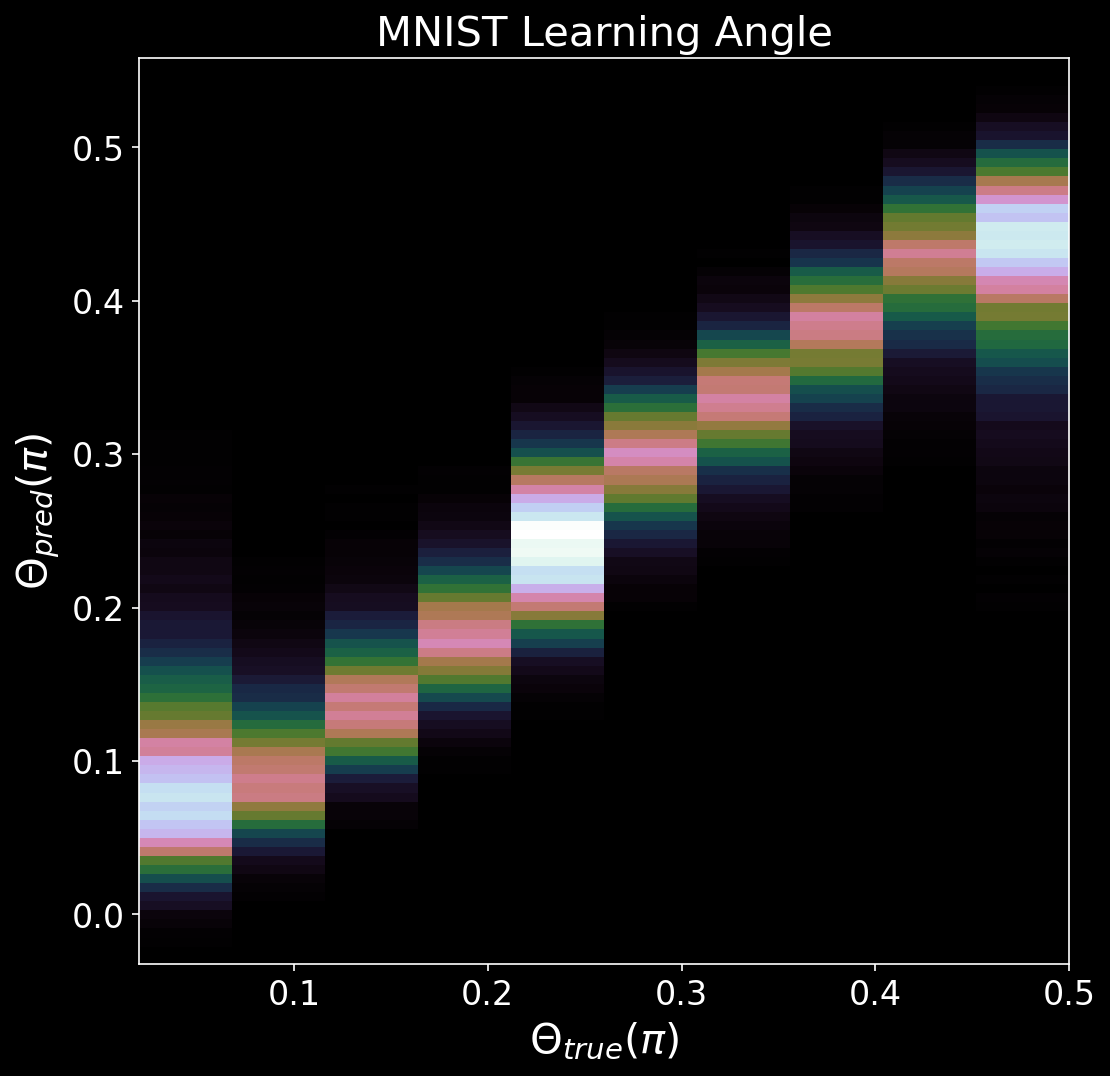

In [59]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi, np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi, 
          bins=[10,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

In [60]:
sc = StandardScaler()
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_size_iso[np.isin(angle_test,angle_array[1:25:2])]))
Y_tr = np.array([np.cos(np.mod(angle_test[np.isin(angle_test,angle_array[1:25:2])],np.pi)),np.sin(np.mod(angle_test[np.isin(angle_test,angle_array[1:25:2])],np.pi))]).T
Y_test = np.array([np.cos(np.mod(angle_test[np.isin(angle_test,angle_array[0:25:2])],np.pi)),np.sin(np.mod(angle_test[np.isin(angle_test,angle_array[0:25:2])],np.pi))]).T
X_test = sc.transform(np.log10(mnist_DHC_out_size_iso[np.isin(angle_test,angle_array[0:25:2])]))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(0.06431249217527135, 0.08064880723785288)

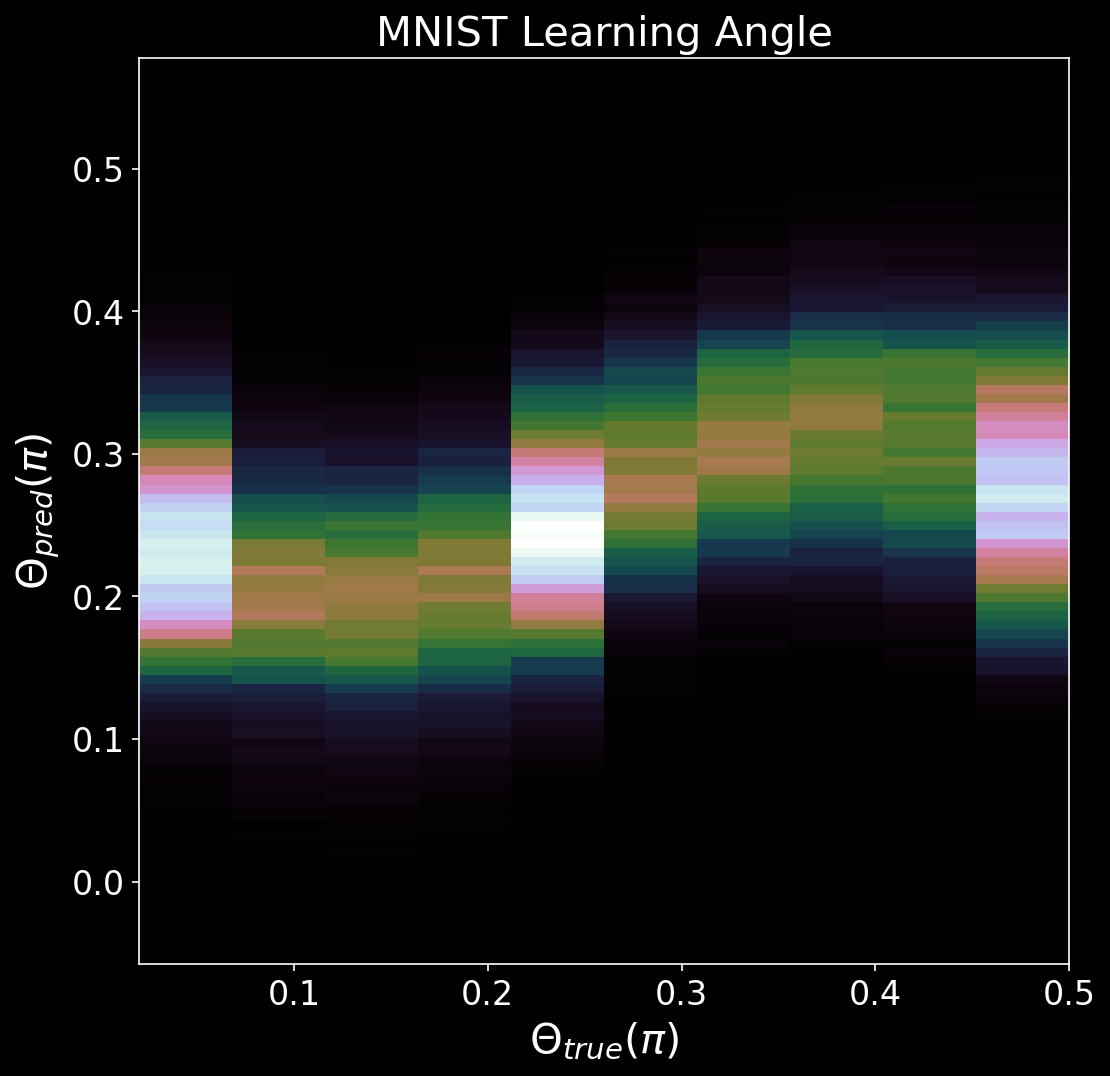

In [61]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi, np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi, 
          bins=[10,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

In [62]:
sc = StandardScaler()
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetest[np.isin(angle_test,angle_array[1:50:2])]))
Y_tr = np.array([np.cos(np.mod(angle_test[np.isin(angle_test,angle_array[1:50:2])],np.pi)),np.sin(np.mod(angle_test[np.isin(angle_test,angle_array[1:50:2])],np.pi))]).T
Y_test = np.array([np.cos(np.mod(angle_test[np.isin(angle_test,angle_array[0:50:2])],np.pi)),np.sin(np.mod(angle_test[np.isin(angle_test,angle_array[0:50:2])],np.pi))]).T
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest[np.isin(angle_test,angle_array[0:50:2])]))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(0.0750567036566669, 0.08122712975157201)

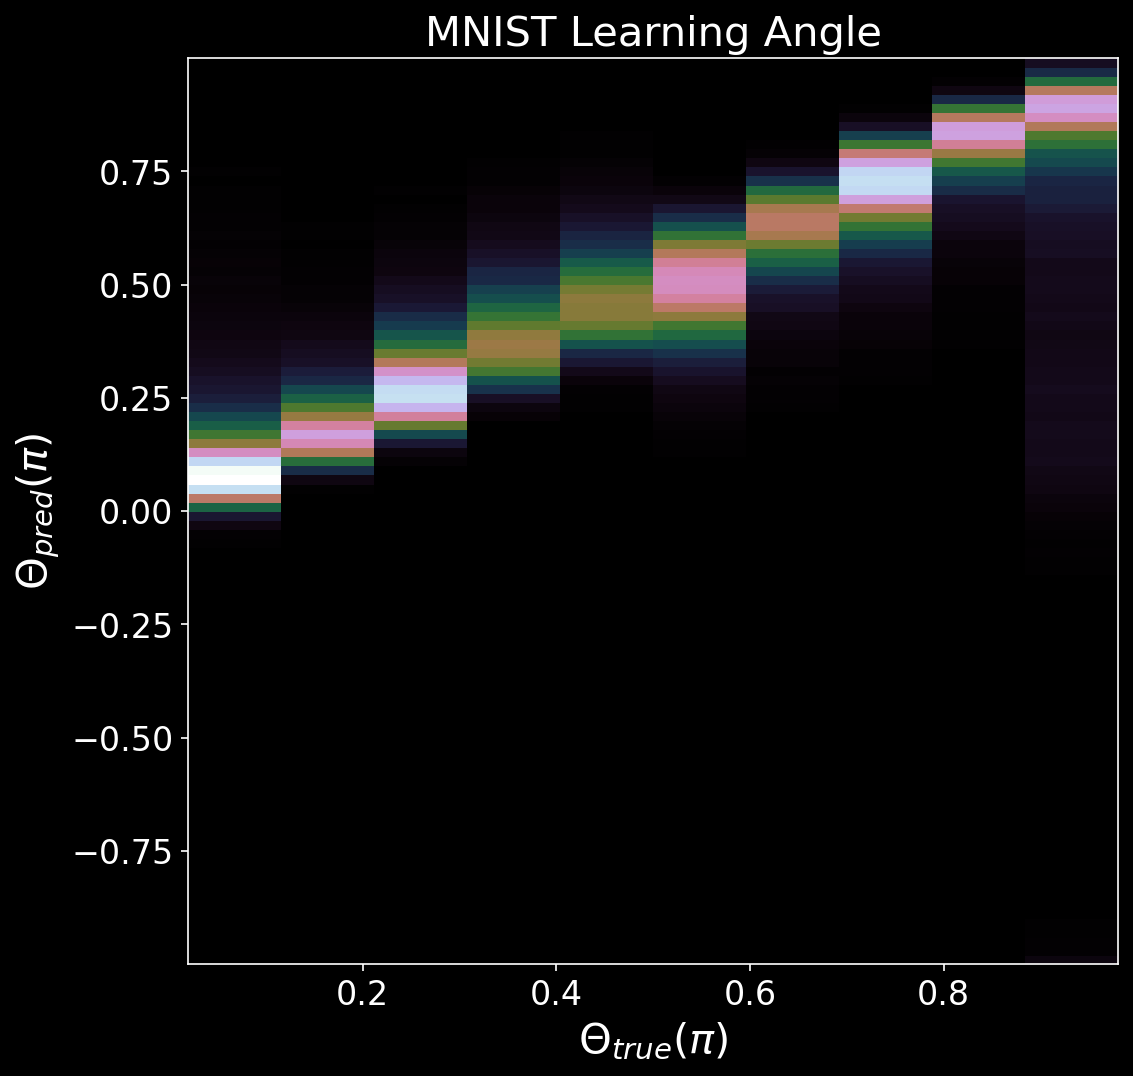

In [63]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi, np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi, 
          bins=[10,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

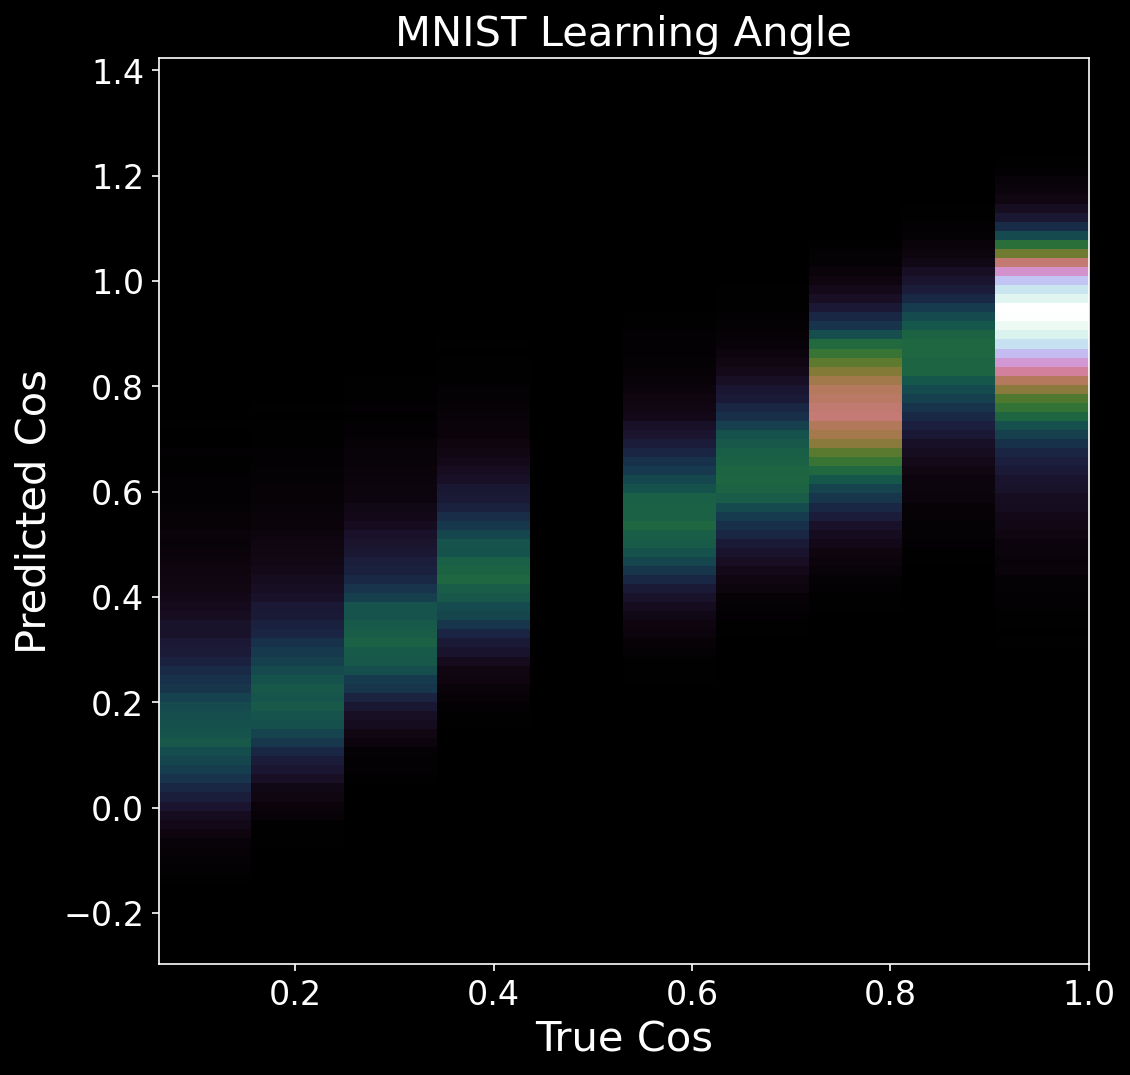

In [70]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(Y_test[:,1], y_pred_test[:,1], 
          bins=[10,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('Predicted Cos')
plt.xlabel('True Cos')
plt.title('MNIST Learning Angle')
plt.show()

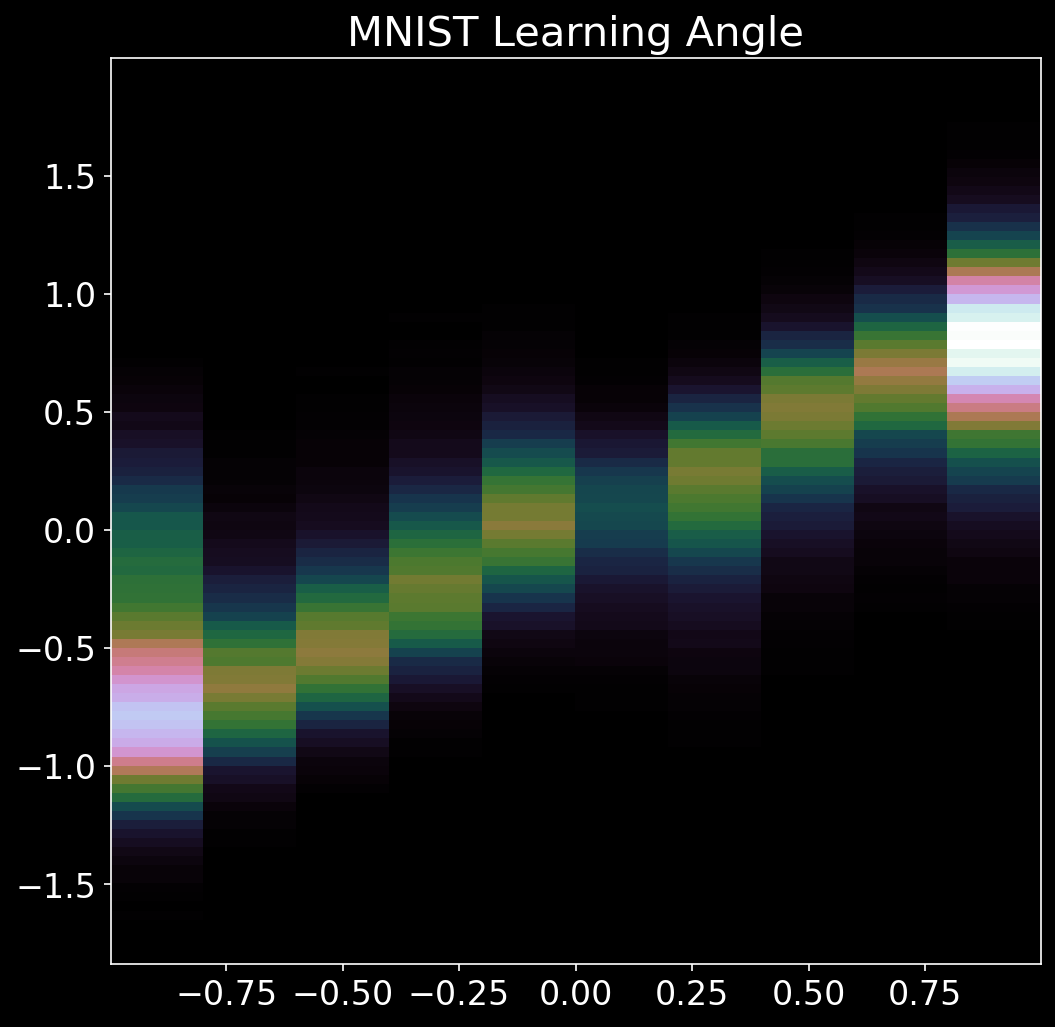

In [66]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(Y_test[:,0], y_pred_test[:,0], 
          bins=[10,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('Predicted Sin')
plt.xlabel('True Sin')
plt.title('MNIST Learning Angle')
plt.show()

In [74]:
np.array(angle_array)[[3,22]]

array([0.25132741, 1.44513262])

In [82]:
sc = StandardScaler()
train_slice = np.isin(angle_test,np.array(angle_array)[[3,22]])
test_slice = np.isin(angle_test,np.array(angle_array)[[0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24]])

X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetest[train_slice]))
Y_tr = np.array([np.cos(np.mod(angle_test[train_slice],np.pi)),np.sin(np.mod(angle_test[train_slice],np.pi))]).T
Y_test = np.array([np.cos(np.mod(angle_test[test_slice],np.pi)),np.sin(np.mod(angle_test[test_slice],np.pi))]).T
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest[test_slice]))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(0.005377102621171537, 0.0318301285606521)

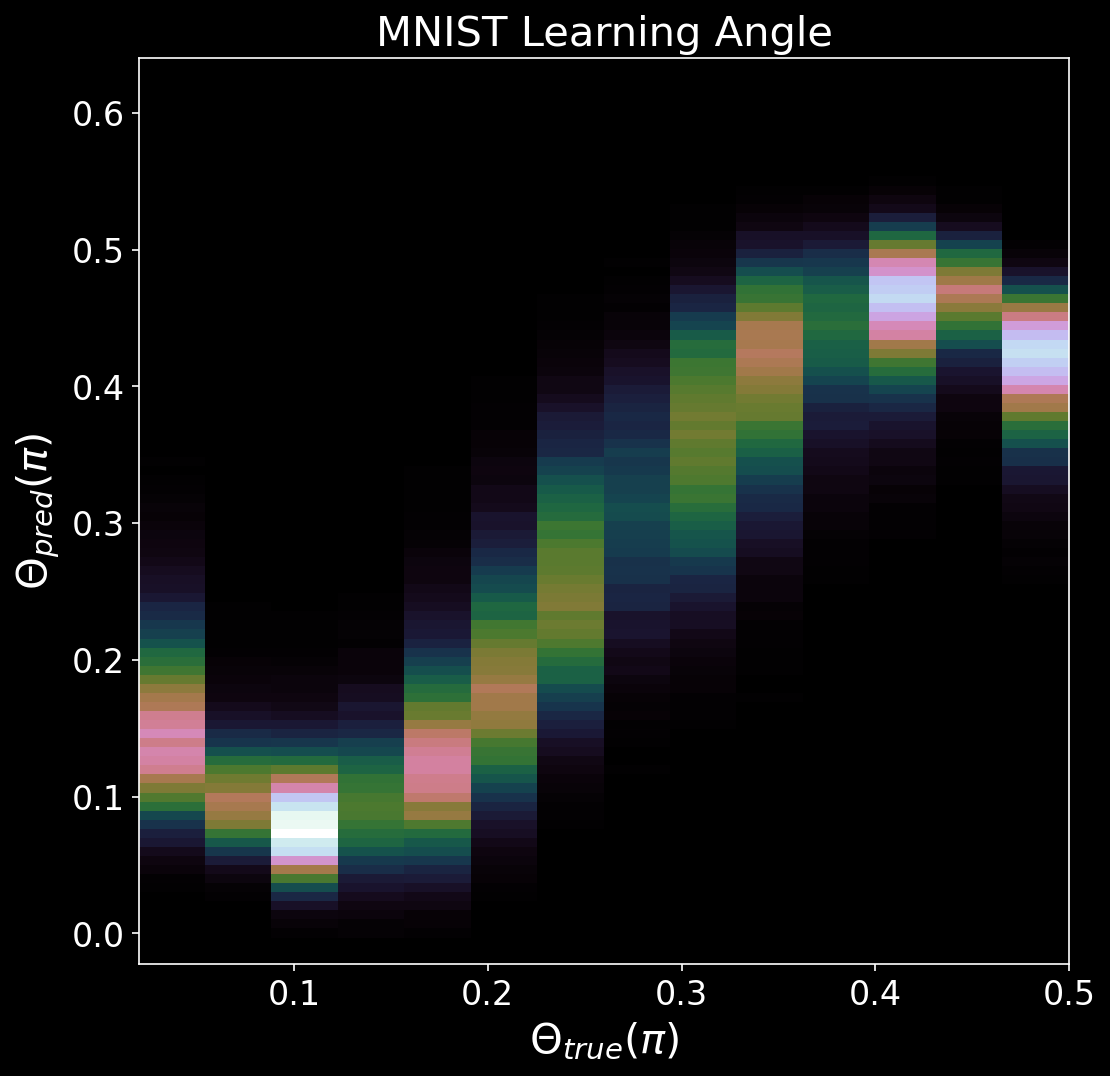

In [83]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi, np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi, 
          bins=[14,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

In [77]:
sc = StandardScaler()
train_slice = np.isin(angle_test,np.array(angle_array)[[3,12,22]])
test_slice = np.isin(angle_test,np.array(angle_array)[[0,1,2,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,23,24]])

X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetest[train_slice]))
Y_tr = np.array([np.cos(np.mod(angle_test[train_slice],np.pi)),np.sin(np.mod(angle_test[train_slice],np.pi))]).T
Y_test = np.array([np.cos(np.mod(angle_test[test_slice],np.pi)),np.sin(np.mod(angle_test[test_slice],np.pi))]).T
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest[test_slice]))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(0.005705878228161493, 0.020706440530956705)

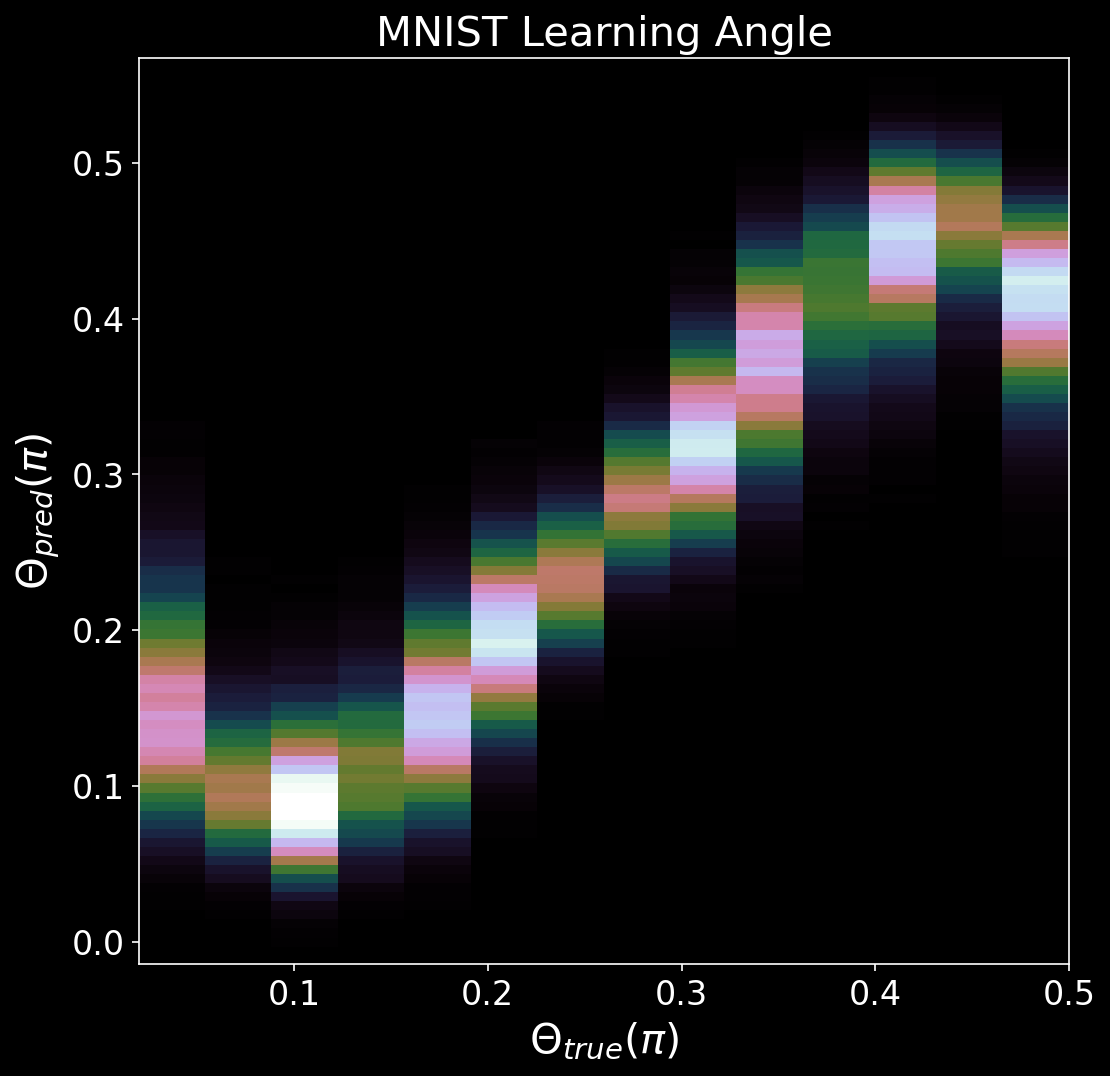

In [81]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi, np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi, 
          bins=[14,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

In [84]:
sc = StandardScaler()
train_slice = np.isin(angle_test,np.array(angle_array)[[0,12,24]])
test_slice = np.isin(angle_test,np.array(angle_array)[[0,1,2,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,23,24]])

X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetest[train_slice]))
Y_tr = np.array([np.cos(np.mod(angle_test[train_slice],np.pi)),np.sin(np.mod(angle_test[train_slice],np.pi))]).T
Y_test = np.array([np.cos(np.mod(angle_test[test_slice],np.pi)),np.sin(np.mod(angle_test[test_slice],np.pi))]).T
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest[test_slice]))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(0.01679879644547665, 0.04068298261921703)

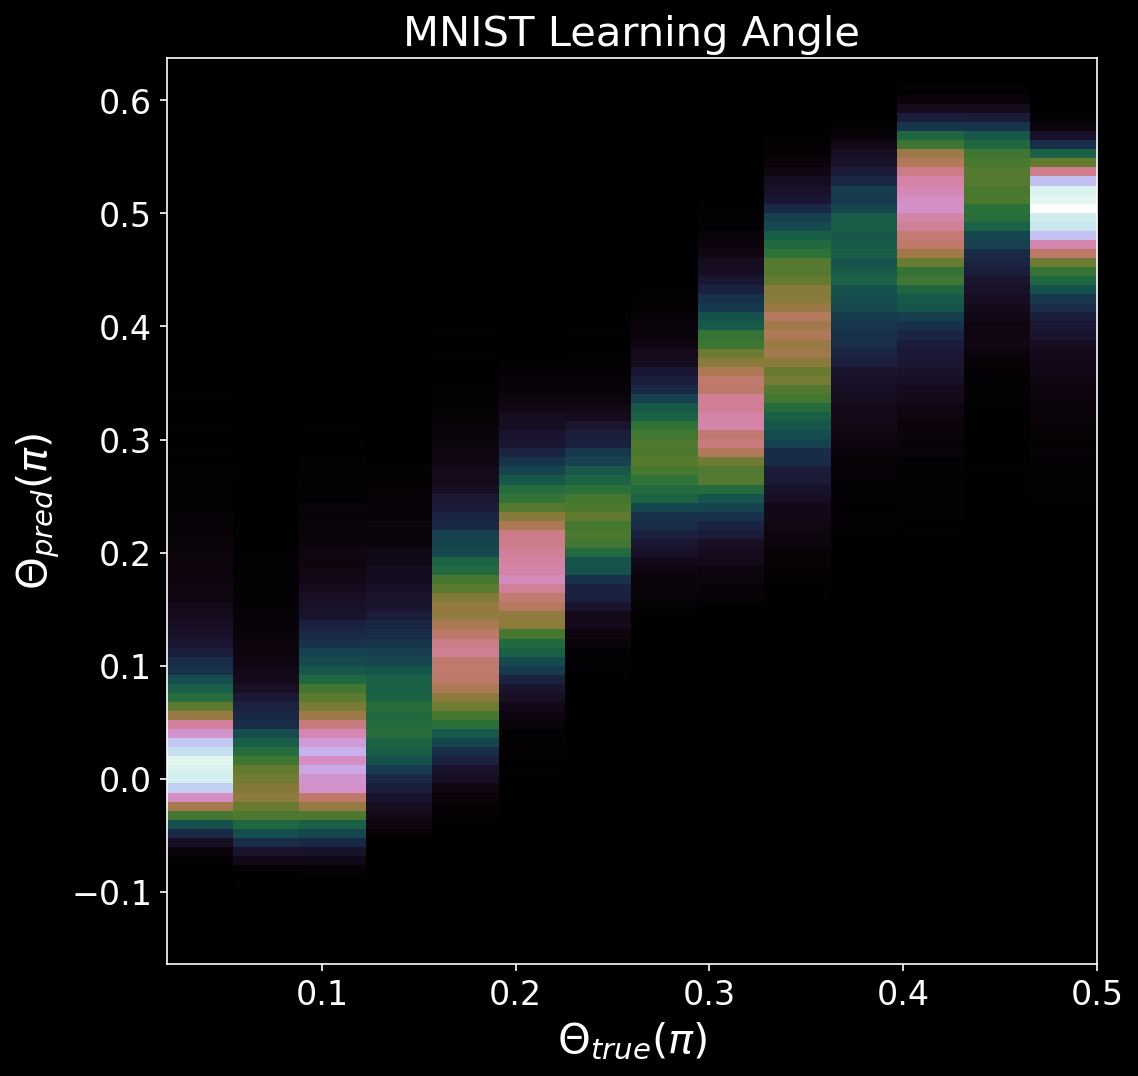

In [85]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi, np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi, 
          bins=[14,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

In [86]:
sc = StandardScaler()
train_slice = np.isin(angle_test,np.array(angle_array)[[0,6,12,18,24]])
test_slice = np.isin(angle_test,np.array(angle_array)[[1,2,3,4,5,7,8,9,10,11,13,14,15,16,17,19,20,21,22,23]])

X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetest[train_slice]))
Y_tr = np.array([np.cos(np.mod(angle_test[train_slice],np.pi)),np.sin(np.mod(angle_test[train_slice],np.pi))]).T
Y_test = np.array([np.cos(np.mod(angle_test[test_slice],np.pi)),np.sin(np.mod(angle_test[test_slice],np.pi))]).T
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest[test_slice]))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(0.016238952803838906, 0.01499449564128022)

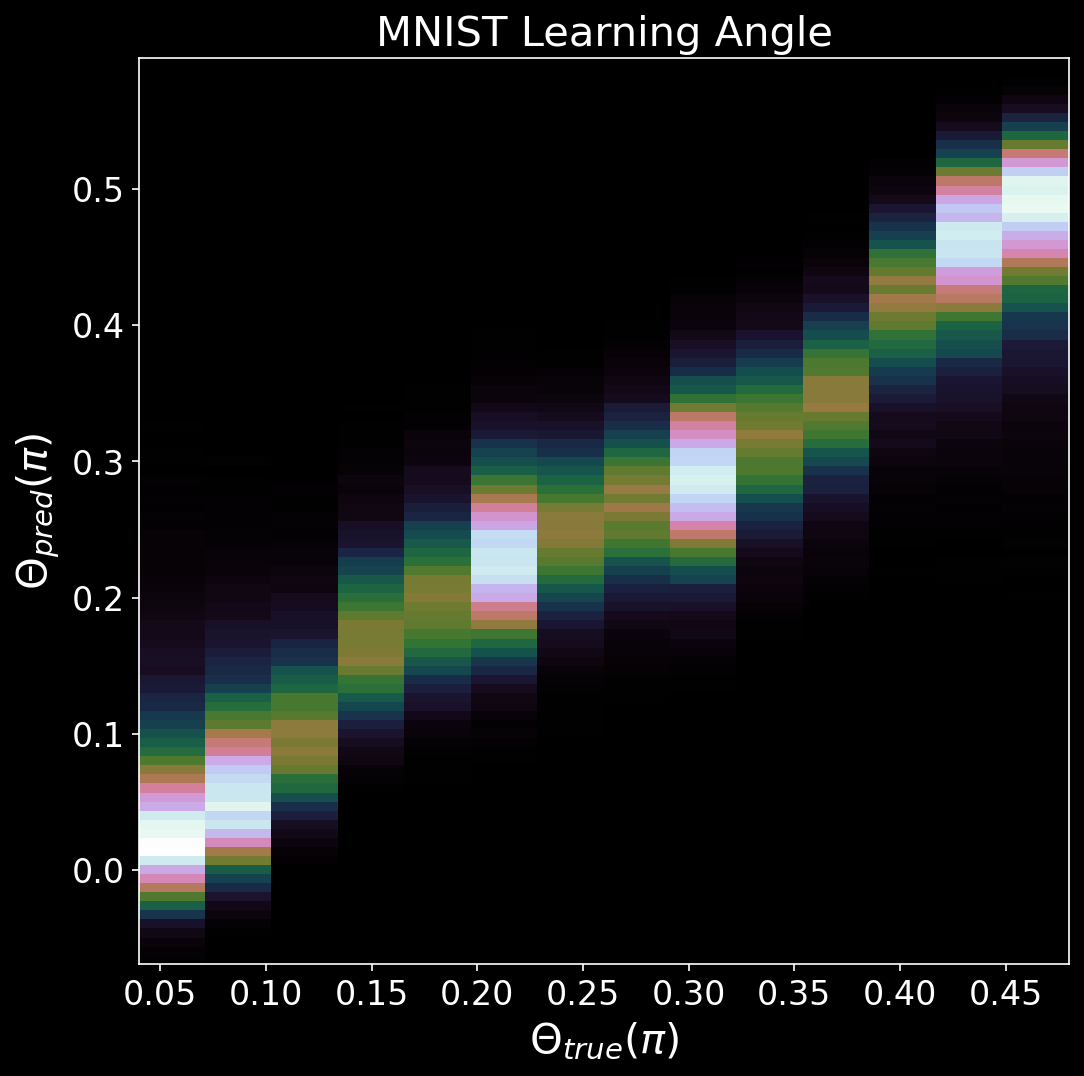

In [87]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi, np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi, 
          bins=[14,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()